--- 355.71358156204224 seconds ---


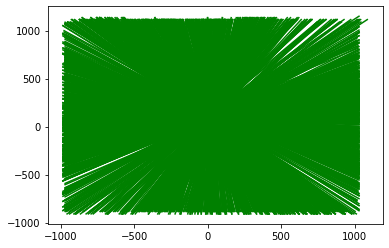

In [1]:
import time
start_time = time.time()

import copy

import MyHoughTransform

import numpy as np
from numpy import unravel_index
import cv2 as cv
from matplotlib import pyplot as plt

""" hyperparameters """
delta_rho = 1 / 2
delta_theta = np.pi / 180 / 2
kernel_size = 0.5


def preprocessing(p):
    p_copy = copy.copy(p)
    p = p.astype(float)
    p_num = p.shape[0]

    for i in range(p_num):
        ind = np.array([j % p_num for j in range(i-2, i+1)])
        p[i, :] = np.sum(p_copy[ind, :], axis=0) / 3

    return p


def find_two_max(rho_line):
    ind_line_1 = 0
    ind_line_2 = 0
    rho_line_1 = 0
    rho_line_2 = 0
    for i in range(1, rho_line.shape[0] - 1):
        if rho_line[i] > rho_line[i - 1] and \
                rho_line[i] > rho_line[i + 1] and \
                rho_line[i] > rho_line_1:
            temp = ind_line_1
            ind_line_1 = i
            ind_line_2 = temp
            temp = rho_line_1
            rho_line_1 = rho_line[i]
            rho_line_2 = temp
        elif rho_line[i] > rho_line[i - 1] and \
                rho_line[i] > rho_line[i + 1] and \
                rho_line[i] > rho_line_2:
            ind_line_2 = i
            rho_line_2 = rho_line[i]

    return [ind_line_1, ind_line_2]


def find_rectangle_param(points):


    def find_intersections(rho_lines, theta_lines):
        k = -np.cos(theta_lines) / np.sin(theta_lines)
        m = rho_lines / np.sin(theta_lines)

        result_points = np.zeros((2, 4))
        result_points[:, 0] = ([
            - (m[0] - m[1]) / (k[0] - k[1]),
            - k[0] * (m[0] - m[1]) / (k[0] - k[1]) + m[0],
        ])
        result_points[:, 1] = ([
            - (m[1] - m[2]) / (k[1] - k[2]),
            - k[1] * (m[1] - m[2]) / (k[1] - k[2]) + m[1],
        ])
        result_points[:, 2] = ([
            - (m[2] - m[3]) / (k[2] - k[3]),
            - k[2] * (m[2] - m[3]) / (k[2] - k[3]) + m[2],
        ])
        result_points[:, 3] = ([
            - (m[3] - m[0]) / (k[3] - k[0]),
            - k[3] * (m[3] - m[0]) / (k[3] - k[0]) + m[3],
        ])

        return result_points

    acc_array, rho, theta, x_centroid, y_centroid = \
        MyHoughTransform.kernel_hough_tramsform(
            points, delta_rho, delta_theta, kernel_size, 0)

    # acc_gray = (acc_array / np.max(acc_array) * 255).astype(np.uint8)
    # scale = 4
    # height, width = acc_gray.shape[:2]
    # res = cv.resize(acc_gray, (scale * width, scale * height),
    #                 interpolation=cv.INTER_AREA)

    # cv.imshow('image', res)
    # cv.waitKey(0)
    # cv.destroyAllWindows()

    theta_long_line_ind = unravel_index(acc_array.argmax(), acc_array.shape)[1]
    if theta_long_line_ind + acc_array.shape[1] // 2 > acc_array.shape[1]:
        theta_short_line_ind = theta_long_line_ind - acc_array.shape[1] // 2
    else:
        theta_short_line_ind = theta_long_line_ind + acc_array.shape[1] // 2

    pho_long_line = acc_array[:, theta_long_line_ind]
    pho_short_line = acc_array[:, theta_short_line_ind]

    # plt.figure()
    # plt.plot(rho, pho_long_line)
    # plt.plot(rho, pho_short_line)
    # plt.show()

    long_lines = find_two_max(pho_long_line)
    short_lines = find_two_max(pho_short_line)

    rho_lines = np.array([rho[long_lines[0]], rho[short_lines[0]],
                          rho[long_lines[1]], rho[short_lines[1]]])
    theta_lines = np.array(
        [theta[theta_long_line_ind], theta[theta_short_line_ind],
         theta[theta_long_line_ind], theta[theta_short_line_ind]])

    result_points = find_intersections(rho_lines, theta_lines)

    result_points[0, :] += x_centroid
    result_points[1, :] += y_centroid

    return result_points, theta_long_line_ind


data = []
with open("input/NN_output/loose") as f:
    for line in f:
        data.append([float(x) for x in line.split()])

ind_num = 3

image = np.array(data)
image_gray = (image / (ind_num - 1) * 255).astype(np.uint8)

height, width = image_gray.shape[:2]
res = cv.resize(image_gray, (2*width, 2*height), interpolation=cv.INTER_AREA)
# cv.imshow('image_1', res)
# cv.waitKey(0)
# cv.destroyAllWindows()

image_ind_2 = (image == 2)
image_ind_2_gray = (image_ind_2 * 255).astype(np.uint8)

# height, width = image_ind_2_gray.shape[:2]
# res = cv.resize(image_ind_2_gray, (2*width, 2*height),
#                 interpolation=cv.INTER_AREA)

edges_ind_2 = cv.Canny(image_ind_2_gray, 100, 200)

# height, width = edges_ind_2.shape[:2]
# res = cv.resize(edges_ind_2, (2*width, 2*height), interpolation=cv.INTER_AREA)

_, contours_ind_2, _ = cv.findContours(
    image_ind_2_gray, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)

#plt.figure(figsize=(7, 7))
point_cloud = []
for contour in contours_ind_2:
    points = []
    for i in contour:
        points.append(i[0].tolist())
    #plt.plot(np.array(points)[:, 0], np.array(points)[:, 1], 'k.')

    point_cloud.append(np.array(points))

rect_points = []
theta_points_ind = []
for points in point_cloud:
    rect, theta = find_rectangle_param(points)
    rect_points.append(rect)
    theta_points_ind.append(theta)

#########################################

image_ind_1 = (image == 1)
image_ind_1_gray = (image_ind_1 * 255).astype(np.uint8)

height, width = image_ind_1_gray.shape[:2]
res = cv.resize(image_ind_1_gray, (2*width, 2*height),
                interpolation=cv.INTER_AREA)
# cv.imshow('image_2', res)
# cv.waitKey(0)
# cv.destroyAllWindows()

edges_ind_1 = cv.Canny(image_ind_1_gray, 100, 200)

# height, width = edges_ind_1.shape[:2]
# res = cv.resize(edges_ind_1, (2*width, 2*height), interpolation=cv.INTER_AREA)
# cv.imshow('image_3', res)
# cv.waitKey(0)
# cv.destroyAllWindows()

_, contours_ind_1, _ = cv.findContours(
    image_ind_1_gray, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)

point_cloud_2 = []
for contour in contours_ind_1:
    points = []
    for i in contour:
        points.append(i[0].tolist())
    #plt.plot(np.array(points)[:, 0], np.array(points)[:, 1], 'k.')
    point_cloud_2.append(preprocessing(np.array(points)))

acc_array_contours = []
x_centroid_contour = []
y_centroid_contour = []
rho_contour = []
for points in point_cloud_2:
    acc_array, rho, theta, x_centroid, y_centroid = \
        MyHoughTransform.kernel_hough_tramsform(
            points, delta_rho, delta_theta, kernel_size, 1)

    x_centroid_contour.append(x_centroid)
    y_centroid_contour.append(y_centroid)
    acc_array_contours.append(acc_array)
    rho_contour.append(rho)

    # plt.figure()
    # plt.plot(rho, acc_array[:, theta_points_ind])
    # plt.show()

    #acc_gray = (acc_array / np.max(acc_array) * 255).astype(np.uint8)
    #scale = 2
    #height, width = acc_gray.shape[:2]
    #res = cv.resize(acc_gray, (scale * width, scale * height),
    #                interpolation=cv.INTER_AREA)
    #
    #cv.imshow('image', res)
    #cv.waitKey(0)
    #cv.destroyAllWindows()

x_centroid_contour = np.array(x_centroid_contour)
y_centroid_contour = np.array(y_centroid_contour)

########################

contour_center = np.zeros((np.array(point_cloud_2).shape[0], 2))
i = 0
for points in point_cloud_2:
    center_x = np.sum(points[:, 0]) // points.shape[0]
    center_y = np.sum(points[:, 1]) // points.shape[0]
    if i != np.array(point_cloud_2).shape[0] - 1:
        contour_center[i, 0] = center_x
        contour_center[i, 1] = center_y
    i += 1

rect_contour = np.zeros(np.array(point_cloud).shape[0])
i = 0
for points in point_cloud:
    center_x = np.sum(points[:, 0]) // points.shape[0]
    center_y = np.sum(points[:, 1]) // points.shape[0]
    min_center = 99999
    j = 0
    for j in range(np.array(point_cloud_2).shape[0]):
        if np.sqrt((center_x - contour_center[j, 0]) ** 2 +
                   (center_y - contour_center[j, 1]) ** 2)\
                < min_center:
            rect_contour[i] = j
            min_center = np.sqrt((center_x - contour_center[j, 0]) ** 2 +
                                 (center_y - contour_center[j, 1]) ** 2)
        j += 1
    i += 1

""" require:
        acc_array_contours,
        rect_contour,
        theta_points_ind;
    out:
        magnet_lines_rho,
        magnet_lines_theta;
        """
magnet_lines_rho = np.zeros((rect_contour.shape[0], 2))
magnet_lines_theta = np.zeros((rect_contour.shape[0], 2))
for j in range(rect_contour.shape[0]):
    i = 0
    for acc_array, rho in zip(acc_array_contours, rho_contour):
        if rect_contour[j] == i:
            magnet_lines_theta[j, :] = \
                np.array([
                    theta[theta_points_ind[j]],
                    theta[theta_points_ind[j]]
                ]).reshape(1, -1)
            rho_ind = np.array((find_two_max(acc_array[:, theta_points_ind[j]])))
            # print(rho_ind)
            # plt.figure()
            # plt.plot(acc_array[:, theta_points_ind[j]])
            # plt.show()
            magnet_lines_rho[j, 0] = rho[rho_ind[0]]
            magnet_lines_rho[j, 1] = rho[rho_ind[1]]
        i += 1

magnet_lines_theta = magnet_lines_theta.reshape(-1, 1)
magnet_lines_rho = magnet_lines_rho.reshape(-1, 1)

k = -np.cos(magnet_lines_theta) / np.sin(magnet_lines_theta)
m = magnet_lines_rho / np.sin(magnet_lines_theta)

for i in range(k.shape[0]):
    ind = int(rect_contour[i // 2])

    lines = MyHoughTransform.get_lines_probabilistic(
        point_cloud_2[ind],
        magnet_lines_rho[i],
        magnet_lines_theta[i],
        kernel_size)
    for j in lines:
        plt.plot([j[0], j[1]], [j[2], j[3]], 'b')

    # x = np.array([-100, 100])
    # y = k[i] * x + m[i]
    # x += x_centroid_contour[ind]
    # y += y_centroid_contour[ind]
    # plt.plot(x, y, 'b')
    #for rect in rect_points:
    #    plt.plot([rect[0, 0], rect[0, 1], rect[0, 2], rect[0, 3], rect[0, 0]],
    #        [rect[1, 0], rect[1, 1], rect[1, 2], rect[1, 3], rect[1, 0]], 'r')

#plt.xlim([0, image.shape[0]])
#plt.ylim([0, image.shape[0]])
#plt.xlabel('x')
#plt.ylabel('y')

def find_all_local_max_array(array):
    #shape_0 = array.shape[0]
    #shape_1 = array.shape[1]
    #if shape_1 % 2 == 0:
    #    new_array = np.empty((shape_0, 2 * shape_1))
    #    new_array[:, 0:shape_1 // 2] = np.flip(array[:, shape_1 // 2:], 0)
    #    new_array[:, shape_1 // 2:3 * (shape_1 // 2)] = array
    #    new_array[:, 3 * (shape_1 // 2):] = np.flip(array[:, :shape_1 // 2], 0)
    #else:
    #    new_array = np.empty((shape_0, 2 * shape_1 - 1))
    #    new_array[:, 0:shape_1 // 2] = np.flip(array[:, shape_1 // 2 + 1:], 0)
    #    new_array[:, shape_1 // 2:3 * (shape_1 // 2) + 1] = array
    #    new_array[:, 3 * (shape_1 // 2) + 1:] = np.flip(array[:, :shape_1 //
    #    2], 0)

    #array = new_array

    def dif_arr(arr, i_p, j_p):
        # 1 2 3
        # 8   4
        # 7 6 5
        dif = arr[i_p, j_p] -\
              np.array([arr[i_p - 1, j_p - 1], arr[i_p - 1, j_p    ],
                        arr[i_p - 1, j_p + 1], arr[i_p    , j_p + 1],
                        arr[i_p + 1, j_p + 1], arr[i_p + 1, j_p    ],
                        arr[i_p + 1, j_p - 1], arr[i_p    , j_p - 1],
                        ])

        return dif


    trash_hold_1 = 0.1
    max_array = np.zeros(array.shape)
    for i in range(1, array.shape[0] - 1):
        for j in range(1, array.shape[1] - 1):
            if array[i, j] > trash_hold_1 * np.max(array):
                i_pntr = i
                j_pntr = j

                dif = dif_arr(array, i_pntr, j_pntr)

                while np.min(dif) < 0:
                    dir = np.argmin(dif) + 1

                    if dir == 1:
                        i_pntr -= 1
                        j_pntr -= 1
                    elif dir == 2:
                        i_pntr -= 1
                    elif dir == 3:
                        i_pntr -= 1
                        j_pntr += 1
                    elif dir == 4:
                        j_pntr += 1
                    elif dir == 5:
                        i_pntr += 1
                        j_pntr += 1
                    elif dir == 6:
                        i_pntr += 1
                    elif dir == 7:
                        i_pntr += 1
                        j_pntr -= 1
                    elif dir == 8:
                        j_pntr -= 1

                    if i_pntr == 0 or i_pntr == array.shape[0] - 1 or\
                        j_pntr == 0 or j_pntr == array.shape[1] - 1:
                        break

                    dif = dif_arr(array, i_pntr, j_pntr)

                max_array[i_pntr, j_pntr] += 1
                # max_array[i_pntr, j_pntr] += array[i, j]

    trash_hold_2 = 0.01
    rho_ind = []
    theta_ind = []
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            if max_array[i, j] > trash_hold_2 * np.max(max_array):
                rho_ind.append(i)
                theta_ind.append(j)

    #rho_ind_new = []
    #theta_ind_new = []
    #if shape_1 % 2 == 0:
    #    for rho_i, theta_i in zip(rho_ind, theta_ind):
    #        if shape_1 // 2 <= theta_i < 3 * (shape_1 // 2):
    #            rho_ind_new.append(rho_i)
    #            theta_ind_new.append(theta_i - shape_1 // 2)
    #else:
    #    for rho_i, theta_i in zip(rho_ind, theta_ind):
    #        if shape_1 // 2 <= theta_i <= 3 * (shape_1 // 2):
    #            rho_ind_new.append(rho_i)
    #            theta_ind_new.append(theta_i - shape_1 // 2)
    #
    #rho_ind = rho_ind_new
    #theta_ind = theta_ind_new

    #acc_gray = (max_array / np.max(max_array) * 255).astype(np.uint8)
    #scale = 2
    #height, width = acc_gray.shape[:2]
    #res = cv.resize(acc_gray, (scale * width, scale * height),
    #                interpolation=cv.INTER_AREA)
    #
    #cv.imshow('image', res)
    #cv.waitKey(0)
    #cv.destroyAllWindows()

    return rho_ind, theta_ind


def find_all_local_max_array_3D(array):
    def dif_arr_3D(arr, i_p, j_p, k_p):
        # 1 2 3 | 10 11 12 | 18 19 20
        # 8 9 4 | 17    13 | 25 26 21
        # 7 6 5 | 16 15 14 | 24 23 22
        dif = arr[i_p, j_p, k_p] -\
              np.array([arr[i_p - 1, j_p - 1, k_p - 1],
                        arr[i_p - 1, j_p    , k_p - 1],
                        arr[i_p - 1, j_p + 1, k_p - 1],
                        arr[i_p    , j_p + 1, k_p - 1],
                        arr[i_p + 1, j_p + 1, k_p - 1],
                        arr[i_p + 1, j_p    , k_p - 1],
                        arr[i_p + 1, j_p - 1, k_p - 1],
                        arr[i_p    , j_p - 1, k_p - 1],
                        arr[i_p    , j_p    , k_p - 1],  # 9
                        arr[i_p - 1, j_p - 1, k_p    ],
                        arr[i_p - 1, j_p    , k_p    ],
                        arr[i_p - 1, j_p + 1, k_p    ],
                        arr[i_p    , j_p + 1, k_p    ],
                        arr[i_p + 1, j_p + 1, k_p    ],
                        arr[i_p + 1, j_p    , k_p    ],
                        arr[i_p + 1, j_p - 1, k_p    ],
                        arr[i_p    , j_p - 1, k_p    ],  # 17

                        arr[i_p - 1, j_p - 1, k_p + 1],
                        arr[i_p - 1, j_p    , k_p + 1],
                        arr[i_p - 1, j_p + 1, k_p + 1],
                        arr[i_p    , j_p + 1, k_p + 1],
                        arr[i_p + 1, j_p + 1, k_p + 1],
                        arr[i_p + 1, j_p    , k_p + 1],
                        arr[i_p + 1, j_p - 1, k_p + 1],
                        arr[i_p    , j_p - 1, k_p + 1],
                        arr[i_p    , j_p    , k_p + 1]   # 26
                        ])

        return dif


    trash_hold_1 = 0.1
    max_array = np.zeros(array.shape)
    for i in range(1, array.shape[0] - 1):
        for j in range(1, array.shape[1] - 1):
            for k in range(1, array.shape[2] - 1):
                if array[i, j, k] > trash_hold_1 * np.max(array):
                    i_pntr = i
                    j_pntr = j
                    k_pntr = k

                    dif = dif_arr_3D(array, i_pntr, j_pntr, k_pntr)

                    while np.min(dif) < 0:
                        dir = np.argmin(dif) + 1

                        if dir == 1:
                            i_pntr -= 1
                            j_pntr -= 1
                            k_pntr -= 1
                        elif dir == 2:
                            i_pntr -= 1

                            k_pntr -= 1
                        elif dir == 3:
                            i_pntr -= 1
                            j_pntr += 1
                            k_pntr -= 1
                        elif dir == 4:

                            j_pntr += 1
                            k_pntr -= 1
                        elif dir == 5:
                            i_pntr += 1
                            j_pntr += 1
                            k_pntr -= 1
                        elif dir == 6:
                            i_pntr += 1

                            k_pntr -= 1
                        elif dir == 7:
                            i_pntr += 1
                            j_pntr -= 1
                            k_pntr -= 1
                        elif dir == 8:

                            j_pntr -= 1
                            k_pntr -= 1
                        elif dir == 9:


                            k_pntr -= 1
                        elif dir == 10:
                            i_pntr -= 1
                            j_pntr -= 1

                        elif dir == 11:
                            i_pntr -= 1


                        elif dir == 12:
                            i_pntr -= 1
                            j_pntr += 1

                        elif dir == 13:

                            j_pntr += 1

                        elif dir == 14:
                            i_pntr += 1
                            j_pntr += 1

                        elif dir == 15:
                            i_pntr += 1


                        elif dir == 16:
                            i_pntr += 1
                            j_pntr -= 1

                        elif dir == 17:

                            j_pntr -= 1

                        elif dir == 18:
                            i_pntr -= 1
                            j_pntr -= 1
                            k_pntr += 1
                        elif dir == 19:
                            i_pntr -= 1

                            k_pntr += 1
                        elif dir == 20:
                            i_pntr -= 1
                            j_pntr += 1
                            k_pntr += 1
                        elif dir == 21:

                            j_pntr += 1
                            k_pntr += 1
                        elif dir == 22:
                            i_pntr += 1
                            j_pntr += 1
                            k_pntr += 1
                        elif dir == 23:
                            i_pntr += 1

                            k_pntr += 1
                        elif dir == 24:
                            i_pntr += 1
                            j_pntr -= 1
                            k_pntr += 1
                        elif dir == 25:

                            j_pntr -= 1
                            k_pntr += 1
                        elif dir == 26:

                            k_pntr += 1

                        if i_pntr == 0 or i_pntr == array.shape[0] - 1 or\
                            j_pntr == 0 or j_pntr == array.shape[1] - 1 or\
                            k_pntr == 0 or k_pntr == array.shape[2] - 1:
                            break

                        dif = dif_arr_3D(array, i_pntr, j_pntr, k_pntr)

                    max_array[i_pntr, j_pntr, k_pntr] += 1

    trash_hold_2 = 0.1
    x_ind = []
    y_ind = []
    r_ind = []
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            for k in range(array.shape[2]):
                if max_array[i, j, k] > trash_hold_2 * np.max(max_array):
                    x_ind.append(i)
                    y_ind.append(j)
                    r_ind.append(k)

    return x_ind, y_ind, r_ind


lines_2 = []
for acc_array_0, rho_contour_0, point_cloud_2_0 in \
        zip(acc_array_contours, rho_contour, point_cloud_2):
    lines_2_0 = []
    rho_ind_0, theta_ind_0 = find_all_local_max_array(acc_array_0)
    rho_0 = rho_contour_0[rho_ind_0]
    theta_0 = theta[theta_ind_0]
    # print(rho_0)
    # print(theta_0 / np.pi * 180)

    for i in range(rho_0.shape[0]):
        lines = MyHoughTransform.get_lines_probabilistic(point_cloud_2_0,
            rho_0[i], theta_0[i], kernel_size)
        # print(lines[0])
        # print(lines[1] / np.pi * 180)
        centroid_x = np.sum(point_cloud_2_0[:, 0]) // point_cloud_2_0.shape[0]
        centroid_y = np.sum(point_cloud_2_0[:, 1]) // point_cloud_2_0.shape[0]
        if np.pi / 4 - np.pi < theta_0[i] < 3 * np.pi / 4 - np.pi or \
                np.pi / 4 < theta_0[i] < 3 * np.pi / 4 or \
                np.pi / 4 + np.pi < theta_0[i] < 3 * np.pi / 4 + np.pi:
            x = np.array([i for i in range(-1000, 1000)])
            a = np.cos(theta_0[i]) / np.sin(theta_0[i])
            b = 1
            c = - rho_0[i] / np.sin(theta_0[i])
            y = - a / b * x - c / b
            plt.plot(x + centroid_x, y + centroid_y, 'g')
        else:
            x = np.array([i for i in range(-1000, 1000)])
            a = np.cos(theta_0[i] + np.pi / 2) / np.sin(theta_0[i] + np.pi / 2)
            b = 1
            c = - rho_0[i] / np.sin(theta_0[i] + np.pi / 2)
            y = - a / b * x - c / b
            plt.plot(y + centroid_x, - x + centroid_y, 'g')
        for j in lines:
            lines_2_0.append(j)
    lines_2.append(lines_2_0)

#delta_x = 5
#delta_y = 5
#delta_r = 1
#acc_circles_0, x_0, y_0, r_0, centroid_x_0, centroid_y_0 = \
#    MyHoughTransform.kernel_hough_transforn_circles(
#        point_cloud_2[2], delta_x, delta_y, delta_r, kernel_size)
#
#acc_array = acc_circles_0[:, :,
#    unravel_index(acc_circles_0.argmax(), acc_circles_0.shape)[2]]
#acc_gray = (acc_array / np.max(acc_array) * 255).astype(np.uint8)
#scale = 4
#height, width = acc_gray.shape[:2]
#res = cv.resize(acc_gray, (scale * width, scale * height),
#                interpolation=cv.INTER_AREA)
#
#cv.imshow('image', res)
#cv.waitKey(0)
#cv.destroyAllWindows()
#
#x_ind, y_ind, r_ind = find_all_local_max_array_3D(acc_circles_0)
#
#ax = plt.gca()
#
#for i in range(np.array(x_ind).shape[0]):
#    x_0_0 = x_0[x_ind[i]] + centroid_x_0
#    y_0_0 = y_0[y_ind[i]] + centroid_y_0
#    r_0_0 = r_0[r_ind[i]]
#    circle = plt.Circle((x_0_0, y_0_0), r_0_0, color='b', fill=False)
#    ax.add_artist(circle)
#    print(x_0_0)
#    print(y_0_0)
#    print(r_0_0)

print("--- %s seconds ---" % (time.time() - start_time))

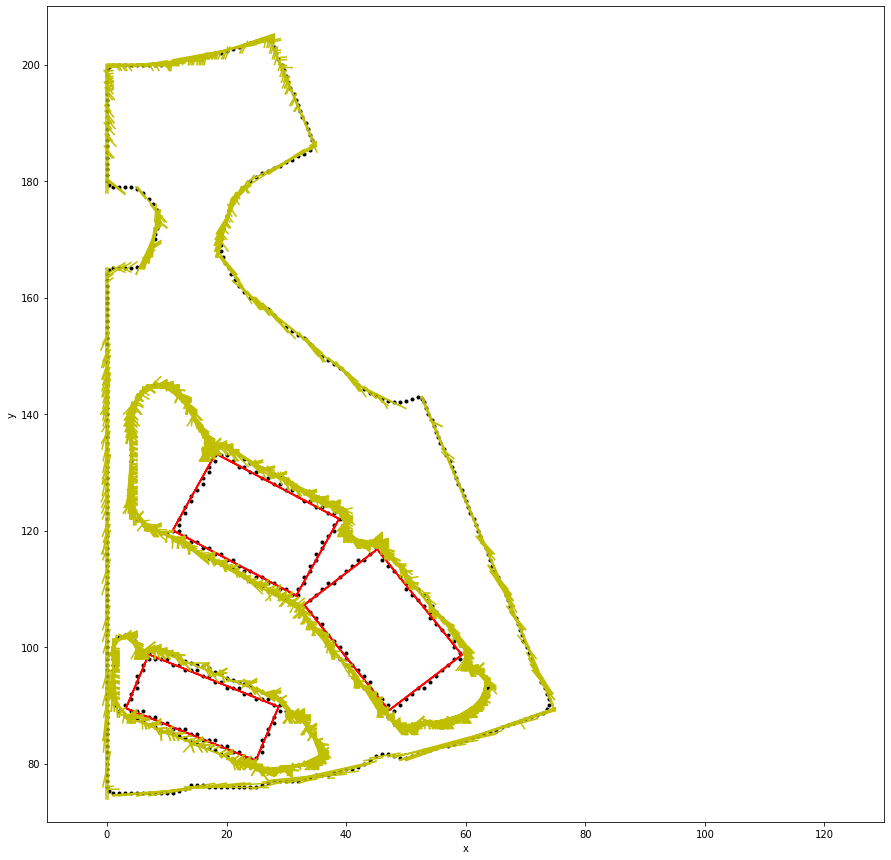

In [2]:
plt.figure(figsize=(15, 15))

for p in point_cloud:
    plt.plot(np.array(p)[:, 0], np.array(p)[:, 1], 'k.')
    
for p in point_cloud_2:
    plt.plot(np.array(p)[:, 0], np.array(p)[:, 1], 'k.')

for i in range(k.shape[0]):
    #for j in lines:
    #    plt.plot([j[0], j[1]], [j[2], j[3]], 'b')

    for rect in rect_points:
        plt.plot([rect[0, 0], rect[0, 1], rect[0, 2], rect[0, 3], rect[0, 0]],
            [rect[1, 0], rect[1, 1], rect[1, 2], rect[1, 3], rect[1, 0]], 'r')

plt.xlim([-10, 130])
plt.ylim([70, 210])
plt.xlabel('x')
plt.ylabel('y')

for lines in lines_2:
    for l in lines:
        plt.plot([l[0], l[1]], [l[2], l[3]], 'y')

plt.show()

[5.0, 10.0, 143.30473208511148, 145.47879395991617]
[[11.0, 144.33333333333334], [10.0, 144.66666666666666], [9.0, 145.0], [8.0, 145.0], [7.0, 144.66666666666666], [6.0, 144.0], [5.333333333333333, 143.0], [4.666666666666667, 142.0]]
[33.33433409432746, 32.69726383351997, 86.0, 85.0]
[[34.333333333333336, 85.0], [33.666666666666664, 86.0], [33.333333333333336, 87.0]]
[16.0, 35.0, 75.79160066962663, 77.28693309929437]
[[36.0, 78.0], [35.0, 78.0], [34.0, 77.66666666666667], [33.0, 77.33333333333333], [32.0, 77.0], [31.0, 77.0], [30.0, 77.0], [29.0, 77.0], [28.0, 77.0], [27.0, 76.66666666666667], [26.0, 76.33333333333333], [25.0, 76.0], [24.0, 76.0], [23.0, 76.0], [22.0, 76.0], [21.0, 76.0], [20.0, 76.0], [19.0, 76.0], [18.0, 76.0], [17.0, 76.0], [16.0, 76.33333333333333], [15.0, 76.33333333333333]]


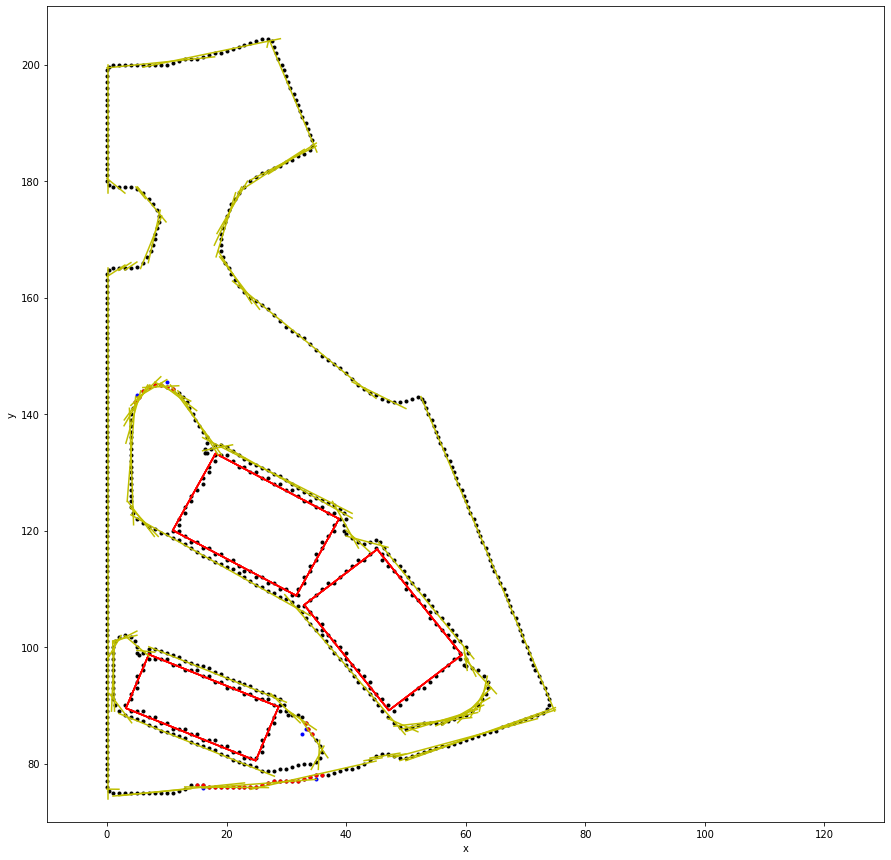

In [3]:
plt.figure(figsize=(15, 15))

for p in point_cloud:
    plt.plot(np.array(p)[:, 0], np.array(p)[:, 1], 'k.')
    
for p in point_cloud_2:
    plt.plot(np.array(p)[:, 0], np.array(p)[:, 1], 'k.')

for i in range(k.shape[0]):
    #for j in lines:
    #    plt.plot([j[0], j[1]], [j[2], j[3]], 'b')

    for rect in rect_points:
        plt.plot([rect[0, 0], rect[0, 1], rect[0, 2], rect[0, 3], rect[0, 0]],
            [rect[1, 0], rect[1, 1], rect[1, 2], rect[1, 3], rect[1, 0]], 'r')

plt.xlim([-10, 130])
plt.ylim([70, 210])
plt.xlabel('x')
plt.ylabel('y')

def find_dist(l, point):
    if np.abs(l[3] - l[2]) < np.abs(l[1] - l[0]):
        b = 1
        a = - b * ((l[3] - l[2]) / (l[1] - l[0]))
        c = - a * l[0] - b * l[2]
        x_0 = point[0]
        y_0 = point[1]
        dist = np.abs(a * x_0 + b * y_0 + c) / np.sqrt(a ** 2 + b ** 2)
        
        p = - a
        m = 1
        t = (m * x_0 + p * y_0 - m * l[0] - p * l[2]) / (m ** 2 + p ** 2)
        x_proj = m * t + l[0]
        y_proj = p * t + l[2]
        
        if l[0] < l[1] < x_proj or l[1] < l[0] < x_proj or x_proj < l[0] < l[1] or x_proj < l[1] < l[0]:
            dist = np.min(np.array([
                np.sqrt((l[0] - x_0)**2 + (l[2] - y_0)**2),
                np.sqrt((l[1] - x_0)**2 + (l[3] - y_0)**2)
            ]))
    else:
        b = 1
        a = - b * ((l[1] - l[0]) / (- l[3] + l[2]))
        c = - a * (- l[2]) - b * l[0]
        x_0 = - point[1]
        y_0 = point[0]
        dist = np.abs(a * x_0 + b * y_0 + c) / np.sqrt(a ** 2 + b ** 2)
        
        p = - a
        m = 1
        t = (m * x_0 + p * y_0 + m * l[2] - p * l[0]) / (m ** 2 + p ** 2)
        x_proj = m * t - l[2]
        y_proj = p * t + l[0]

        if -l[2] < -l[3] < x_proj or -l[3] < -l[2] < x_proj or x_proj < -l[2] < -l[3] or x_proj < -l[3] < -l[2]:
            dist = np.min(np.array([
                np.sqrt((-l[2] - x_0)**2 + (l[0] - y_0)**2),
                np.sqrt((-l[3] - x_0)**2 + (l[1] - y_0)**2)
            ]))
    
    return dist

dist_trashhold = 2
lines_points_2 = []
for lines, points in zip(lines_2, point_cloud_2):
    lines_points = []
    for l in lines:
        points_list = []
        for p in points:
            if find_dist(l, p) < dist_trashhold:
                points_list.append(p.tolist())
        lines_points.append(points_list)
    lines_points_2.append(lines_points)

def list_compare(list_1, list_2, list_3, list_4):
    success = np.zeros(len(list_1))
    
    i = 0
    for l_1 in list_1:
        for l_2 in list_2:
            if l_1 == l_2:
                success[i] = 1
                break
        i += 1
        
    if np.all(success == 1):
        if (list_3[0] - list_3[1]) ** 2 + (list_3[2] - list_3[3]) ** 2 > \
            (list_4[0] - list_4[1]) ** 2 + (list_4[2] - list_4[3]) ** 2 and \
            len(list_1) == len(list_2):
            return False
        else:
            return True
    else:
        return False
    
lines_2_sort_1 = []
lines_points_sort_1 = []
for lines, l_p in zip(lines_2, lines_points_2):
    p_num = 20
    print(lines[p_num])
    print(l_p[p_num])
    plt.plot([lines[p_num][0], lines[p_num][1]], [lines[p_num][2], lines[p_num][3]], 'b.')
    ptn_x = []
    ptn_y = []
    for ptn in l_p[p_num]:
        ptn_x.append(ptn[0])
        ptn_y.append(ptn[1])
    plt.plot(np.array(ptn_x), np.array(ptn_y), 'r.')
    lines_1 = []
    l_p_1 = []
    for i in range(len(lines)):
        success = False
        
        for j in range(len(lines)):
            if not i == j:
                if list_compare(l_p[i], l_p[j], lines[i], lines[j]):
                    success = True
                    break
        
        if not success:
            lines_1.append(lines[i])
            l_p_1.append(l_p[i])

    lines_2_sort_1.append(lines_1)
    lines_points_sort_1.append(l_p_1)
    
for lines in lines_2_sort_1:
    for l in lines:
        plt.plot([l[0], l[1]], [l[2], l[3]], 'y')

plt.show()

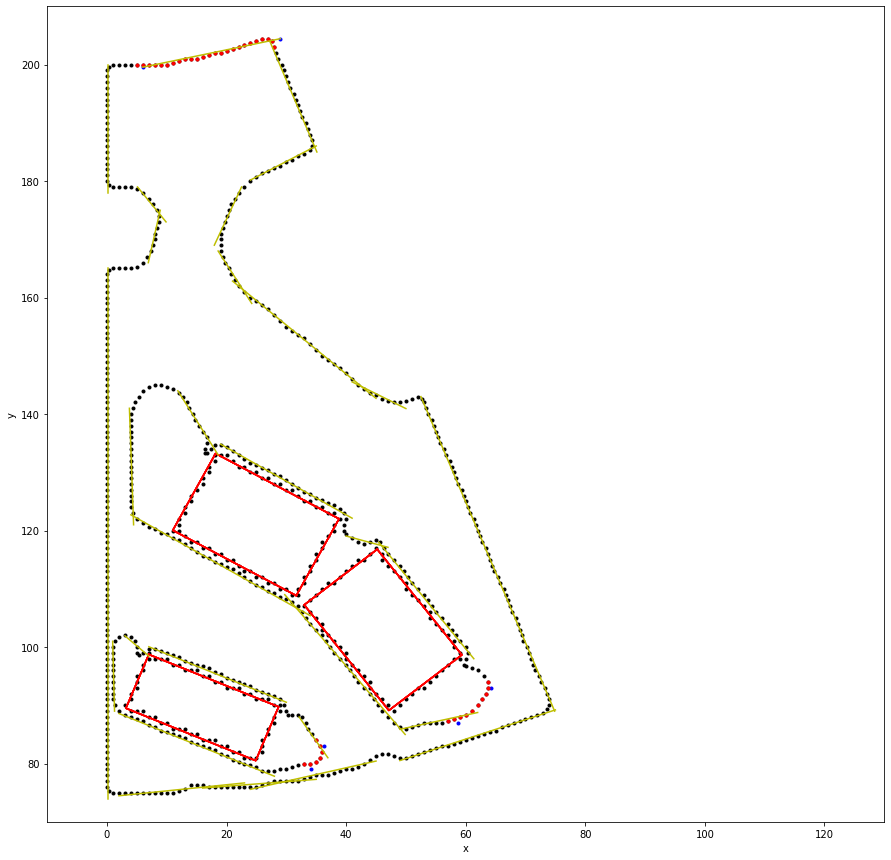

In [4]:
def list_compare_2(list_1, list_2, list_3, list_4, list_5, list_6):
    success = np.zeros(len(list_1))
    success_count_1 = 0
    success_count_2 = 0
    trig = 0.7
    trig_2 = 2
    
    i = 0
    for l_1 in list_1:
        for l_2 in list_2:
            if l_1 == l_2:
                success[i] = 1
                success_count_1 += 1
                break
        for l_3 in list_3:
            if l_1 == l_3:
                success[i] = 1
                success_count_2 += 1
                break
        i += 1
    
    if np.sum(success) >= len(list_1) - trig_2:
        score_1, score_2, score_3 = 0, 0, 0
        for p in points:
            score_1 += 1 / (2 * np.pi * kernel_size) * np.exp(- find_dist(list_4, p) ** 2 / (kernel_size ** 2 / 2))
            score_2 += 1 / (2 * np.pi * kernel_size) * np.exp(- find_dist(list_5, p) ** 2 / (kernel_size ** 2 / 2))
            score_3 += 1 / (2 * np.pi * kernel_size) * np.exp(- find_dist(list_6, p) ** 2 / (kernel_size ** 2 / 2))
        if (success_count_1 > trig * len(list_2) and score_1 > score_2) or (success_count_2 > trig * len(list_3) and score_1 > score_3):
            return False
        elif (score_1 > score_2 or score_1 > score_3) and (success_count_1 < trig * len(list_2) and success_count_2 < trig * len(list_3)):
            return False
        else:
            return True
    else:
        return False

plt.figure(figsize=(15, 15))

for p in point_cloud:
    plt.plot(np.array(p)[:, 0], np.array(p)[:, 1], 'k.')
    
for p in point_cloud_2:
    plt.plot(np.array(p)[:, 0], np.array(p)[:, 1], 'k.')

for i in range(k.shape[0]):
    #for j in lines:
    #    plt.plot([j[0], j[1]], [j[2], j[3]], 'b')

    for rect in rect_points:
        plt.plot([rect[0, 0], rect[0, 1], rect[0, 2], rect[0, 3], rect[0, 0]],
            [rect[1, 0], rect[1, 1], rect[1, 2], rect[1, 3], rect[1, 0]], 'r')

plt.xlim([-10, 130])
plt.ylim([70, 210])
plt.xlabel('x')
plt.ylabel('y')

lines_2_sort_2 = []
lines_points_sort_2 = []
for lines, l_p, points in zip(lines_2_sort_1, lines_points_sort_1, point_cloud_2):
    p_num = 0
    plt.plot([lines[p_num][0], lines[p_num][1]], [lines[p_num][2], lines[p_num][3]], 'b.')
    ptn_x = []
    ptn_y = []
    for ptn in l_p[p_num]:
        ptn_x.append(ptn[0])
        ptn_y.append(ptn[1])
    plt.plot(np.array(ptn_x), np.array(ptn_y), 'r.')
    lines_1 = []
    l_p_1 = []
    for i in range(len(lines)):
        success = False
        
        for j in range(len(lines)):
            for l in range(len(lines)):
                if not i == j and not i == l:
                    if list_compare_2(l_p[i], l_p[j], l_p[l], lines[i], lines[j], lines[l]):
                        success = True
                        break
            
        if not success:
            lines_1.append(lines[i])
            l_p_1.append(l_p[i])

    lines_2_sort_2.append(lines_1)
    lines_points_sort_2.append(l_p_1)
    
for lines in lines_2_sort_2:
    for l in lines:
        plt.plot([l[0], l[1]], [l[2], l[3]], 'y')

plt.show()

In [5]:
print(lines_2_sort_2)

[[[49.0, 62.0, 85.88106245926542, 88.76309307362364], [3.7513984704359835, 4.44981386027094, 141.0, 121.0], [4.0, 34.0, 122.70807007202043, 105.38756199633167], [40.0, 47.0, 119.06739959880335, 117.12612779038447], [29.736509540595684, 49.8749006888504, 109.0, 85.0], [11.850253652252306, 18.59106232179156, 144.0, 133.0], [19.0, 41.0, 134.83242572500257, 122.13071980283081], [45.44891736381409, 61.35763569717065, 118.0, 98.0]], [[0.9491911649611922, 1.2634222237914337, 101.0, 89.0], [32.13579854587391, 36.9467652560852, 88.0, 81.0], [2.0, 28.0, 88.59522875787589, 77.8256761361754], [3.0, 7.0, 101.93251808603581, 98.45537113477091], [7.0, 30.0, 100.05406344966534, 90.52715151508414]], [[6.0, 29.0, 199.56673445512752, 204.45553537353803], [16.0, 35.0, 75.79160066962663, 77.28693309929437], [2.0, 23.0, 74.47058048549408, 76.6777694260733], [24.0, 45.0, 75.57883249730074, 80.42706451093757], [24.0, 35.0, 180.18751413097078, 186.03631787924704], [27.239653970786083, 35.10971165587489, 204.0,

In [6]:
segment_2 = []
for points, lines in zip(point_cloud_2, lines_2_sort_2):
    segment = np.zeros(len(points))
    j = 0
    for p in points:
        line_dist = np.zeros(len(lines))
        i = 0
        for l in lines:
            line_dist[i] = find_dist(l, p)
            i += 1
        segment[j] = np.argmin(line_dist)
        j += 1
    segment_2.append(segment)

print(segment_2)

[array([4., 4., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 3., 3., 3., 3.,
       3., 3., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 5., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 4., 4., 2., 2., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]), array([2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 3., 3., 3.,
       3., 3., 3., 3., 0., 0., 0., 0., 0.,

In [7]:
def num_border(l):
    num = 0
    
    for i in range(len(l)):
        if not l[i % len(l)] == l[(i - 1) % len(l)]:
            num += 1
            
    return num

segment_2_sort = []
for segment in segment_2:
    #print(segment)
    j = 0
    segment_sort = copy.copy(segment)
    while num_border(segment) > np.max(segment) + 1:
        for i in range(len(segment)):
            if not segment[i % len(segment)] == segment[(i - 1) % len(segment)]:
                left = i - 1
                right = i + 1
                while segment[left % len(segment)] == segment[(left - 1) % len(segment)]:
                    left = left - 1
                while segment[right % len(segment)] == segment[(right - 1) % len(segment)]:
                    right = right + 1
                
                if np.abs(left - i) >= np.abs(right - i):
                    segment_sort[i % len(segment)] = segment[(i - 1) % len(segment)]
                else:
                    segment_sort[(i - 1) % len(segment)] = segment[i % len(segment)]
                #print(segment_sort)
        j += 1
        segment = copy.copy(segment_sort)
    segment_2_sort.append(segment_sort)
        
print(segment_2_sort)

[array([4., 4., 4., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7.,
       7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 7., 3., 3., 3.,
       3., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 5., 5., 5., 5., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.]), array([2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 3., 3., 3.,
       3., 3., 3., 3., 0., 0., 0., 0., 0.,

Text(0, 0.5, 'y')

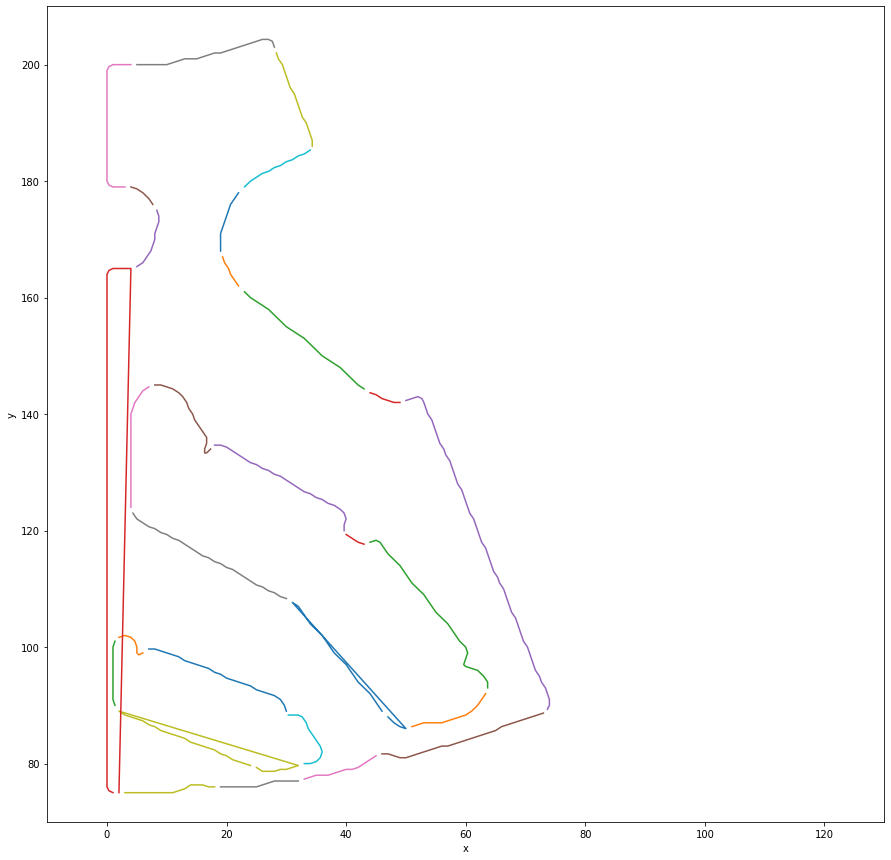

In [8]:
segment_points_2 = []
for segment, points in zip(segment_2_sort, point_cloud_2):
    segment_points = []
    temp = -1
    counter = 0
    iterator = 0
    while iterator < max(segment) + 1:
        while segment[counter] == temp:
            counter += 1
        temp = segment[counter]
        s_p = []
        
        for j in range(len(segment)):
            if segment[j] == temp:
                s_p.append(points[j].tolist())
        if not s_p == []:
            segment_points.append(s_p)
            
        iterator += 1
    segment_points_2.append(segment_points)

#print(segment_points_2)
    
plt.figure(figsize=(15, 15))

#for p in point_cloud:
#    plt.plot(np.array(p)[:, 0], np.array(p)[:, 1], 'k.')
    
for segment_points in segment_points_2:
    #print(segment_points)
    for p in segment_points:
        #print(p)
        plt.plot(np.array(p)[:, 0], np.array(p)[:, 1])

#for i in range(k.shape[0]):
    #for j in lines:
    #    plt.plot([j[0], j[1]], [j[2], j[3]], 'b')

#    for rect in rect_points:
#        plt.plot([rect[0, 0], rect[0, 1], rect[0, 2], rect[0, 3], rect[0, 0]],
#            [rect[1, 0], rect[1, 1], rect[1, 2], rect[1, 3], rect[1, 0]], 'r')

plt.xlim([-10, 130])
plt.ylim([70, 210])
plt.xlabel('x')
plt.ylabel('y')

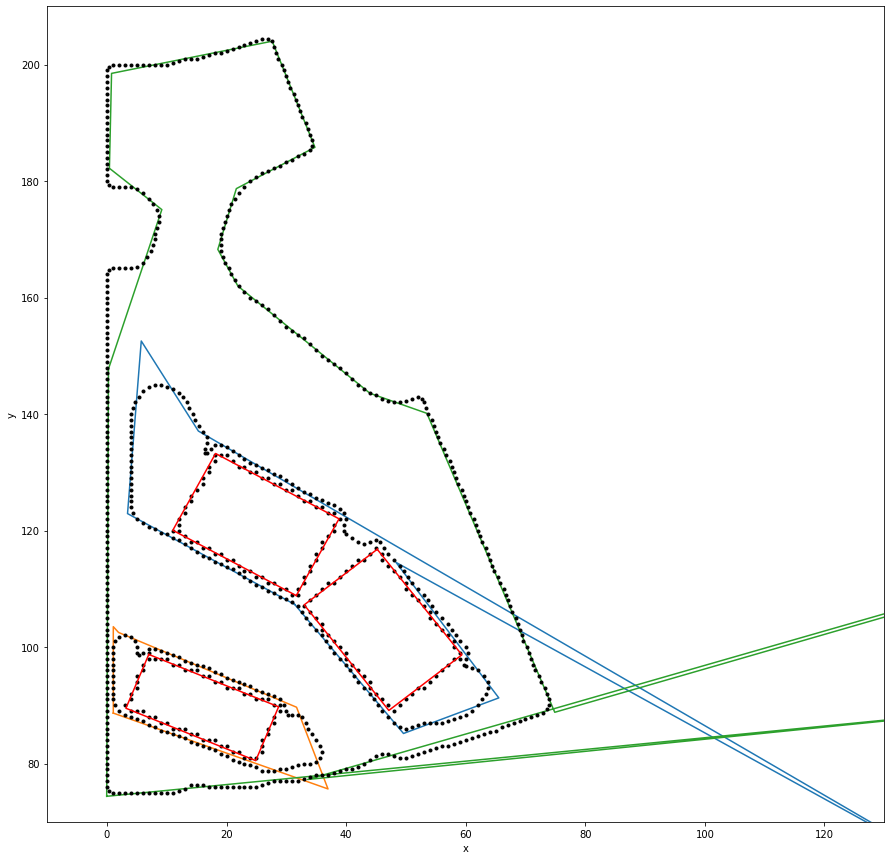

In [9]:
plt.figure(figsize=(15, 15))

def find_param(p):
    x = np.array(p)[:, 0]
    y = np.array(p)[:, 1]
    
    if np.abs(np.max(x) - np.min(x)) > np.abs(np.max(y) - np.min(y)):
        A = np.concatenate((np.ones(x.shape[0]).reshape(x.shape[0], -1), x.reshape(x.shape[0], -1)), axis=1)
        b = y
        coef = np.linalg.inv(A.T @ A) @ A.T @ b
        
        b, k = coef[0], coef[1]
    else:
        x = - np.array(p)[:, 1]
        y = np.array(p)[:, 0]
        A = np.concatenate((np.ones(x.shape[0]).reshape(x.shape[0], -1), x.reshape(x.shape[0], -1)), axis=1)
        b = y
        coef = np.linalg.inv(A.T @ A) @ A.T @ b
        
        b, k = coef[0] / coef[1], - 1 / coef[1]
    
    return b, k

def find_intersection(p_1, p_2):
    b_1, k_1 = find_param(p_1)
    b_2, k_2 = find_param(p_2)
    
    x = - (b_1 - b_2) / (k_1 - k_2)
    y = k_1 * x + b_1
    
    return [x, y]

final_points_2 = []
for segment_points in segment_points_2:
    final_points = []
    for i in range(len(segment_points)):
        final_points.append(find_intersection(segment_points[i], segment_points[(i - 1) % len(segment_points)]))
    final_points_2.append(final_points)

for final_points in final_points_2:
    plt.plot(np.concatenate((np.array(final_points)[:, 0], np.array(final_points)[0:1, 0])), np.concatenate((np.array(final_points)[:, 1], np.array(final_points)[0:1, 1])))
    
plt.xlim([-10, 130])
plt.ylim([70, 210])
plt.xlabel('x')
plt.ylabel('y')

for p in point_cloud:
    plt.plot(np.array(p)[:, 0], np.array(p)[:, 1], 'k.')
    
for p in point_cloud_2:
    plt.plot(np.array(p)[:, 0], np.array(p)[:, 1], 'k.')

for rect in rect_points:
    plt.plot([rect[0, 0], rect[0, 1], rect[0, 2], rect[0, 3], rect[0, 0]],
        [rect[1, 0], rect[1, 1], rect[1, 2], rect[1, 3], rect[1, 0]], 'r')

In [10]:
num_loop = 1000
file = open("test_2.geo", "w")

for final_points in final_points_2:
    num_point = 0
    loop_string = ""
    for p in final_points:
        file.write("Point(" + str(num_loop + num_point) + ") = {" + str(p[0]) + "," + str(p[1]) + ",0,1};" + '\n')
        loop_string += str(num_loop + num_point) + ","
        num_point += 1
    num_point = 0
    for p in final_points:
        file.write("Line(" + str(num_loop + num_point) + ") = {" + str(num_loop + num_point) + "," + str(num_loop + (num_point + 1) % len(final_points)) + "};" + '\n')
        num_point += 1
    loop_string = loop_string[:-1]
    file.write("Line Loop(" + str(num_loop) + ") = {" + loop_string + "};" + '\n')
    num_loop += 1000

for rect in rect_points:
    num_point = 0
    loop_string = ""
    for j in range(4):
        file.write("Point(" + str(num_loop + num_point) + ") = {" + str(rect[0, j]) + "," + str(rect[1, j]) + ",0,1};" + '\n')
        loop_string += str(num_loop + num_point) + ","
        num_point += 1
    num_point = 0
    for j in range(4):
        file.write("Line(" + str(num_loop + num_point) + ") = {" + str(num_loop + num_point) + "," + str(num_loop + (num_point + 1) % 4) + "};" + '\n')
        num_point += 1
    loop_string = loop_string[:-1]
    file.write("Line Loop(" + str(num_loop) + ") = {" + loop_string + "};" + '\n')
    num_loop += 1000
    
file.close()